In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set environment variables
import os

os.environ["SCAL_TYPE"] = "complex"
os.environ["PRECISION"] = "double"
os.environ["MY_NUMBA_TARGET"] = "numba"
 
# Add cle_fun to PYTHON_PATH
import sys
sys.path.append("../../clonscal")

In [2]:
from src.numba_target import myjit, my_parallel_loop
from numba import cuda
from simulation.langevin_dynamics import arr_abs


Using Numba
Using double precision
Using C^1


/home/fhelmberger/miniconda3/envs/cle_cuda/lib/python3.10/site-packages/llvmlite/llvmpy/__init__.py:3: UserWarning: The module `llvmlite.llvmpy` is deprecated and will be removed in the future.
  warnings.warn(
/home/fhelmberger/miniconda3/envs/cle_cuda/lib/python3.10/site-packages/llvmlite/llvmpy/core.py:8: UserWarning: The module `llvmlite.llvmpy.core` is deprecated and will be removed in the future. Equivalent functionality is provided by `llvmlite.ir`.
  warnings.warn(
/home/fhelmberger/miniconda3/envs/cle_cuda/lib/python3.10/site-packages/llvmlite/llvmpy/passes.py:17: UserWarning: The module `llvmlite.llvmpy.passes` is deprecated and will be removed in the future. If you are using this code, it should be inlined into your own project.
  warnings.warn(


In [3]:
from simulation.config import Config
from simulation.cl_simulation import ComplexLangevinSimulation
from simulation.gpu_handler import GPU_handler

config = Config(dims = [1], trajs = int(1e5), mass_real = 1j)
sim = ComplexLangevinSimulation(config)

from src.numba_target import use_cuda
if use_cuda: 
    gpu_handler = GPU_handler(sim)
    gpu_handler.to_device()

In [4]:
# sim.cldyn_kernel_args = sim.cldyn_kernel_bridge.get_current_params()
# sim.update_noise(*sim.cldyn_kernel_args[sim.noise_kernel].values())
# sim.update_drift(*sim.cldyn_kernel_args[sim.drift_kernel].values())
# if sim.ada_step: sim.set_apative_stepsize()
# sim.update_field(*sim.cldyn_kernel_args[sim.evolve_kernel].values())

# print("noise: ")
# %timeit sim.update_noise(*sim.cldyn_kernel_args[sim.noise_kernel].values())

# print("drift: ")
# %timeit sim.update_drift(*sim.cldyn_kernel_args[sim.drift_kernel].values())

# print("adative step:")
# %timeit sim.set_apative_stepsize()

# print("field update:")
# %timeit sim.update_field(*sim.cldyn_kernel_args[sim.evolve_kernel].values())

In [5]:
from src.obs_kernels import n_moment_kernel
from tqdm import tqdm

def run_simulation(config, n_steps = int(1e4)):
    # define simulation parameters

    sim = ComplexLangevinSimulation(config)
    from src.numba_target import use_cuda
    if use_cuda: 
        gpu_handler = GPU_handler(sim)
        gpu_handler.to_device()

    # register observable
    sim.register_observable('1_moment', obs_kernel=n_moment_kernel, const_params={'order': 1}, langevin_history=True)

    # start the loop 
    for _ in tqdm(range(n_steps)):
        sim.step()
        sim.compute('1_moment')

    sim.finish()
    if use_cuda: gpu_handler.to_host()
    return sim

In [6]:
config = Config(dims = [1], trajs = int(1e4), mass_real = 1j+1, interaction=12, dt = 1e-2)
sim = run_simulation(config, n_steps = int(1e4))

100%|██████████| 10000/10000 [00:02<00:00, 3394.15it/s]


(-10.0, 10.0)

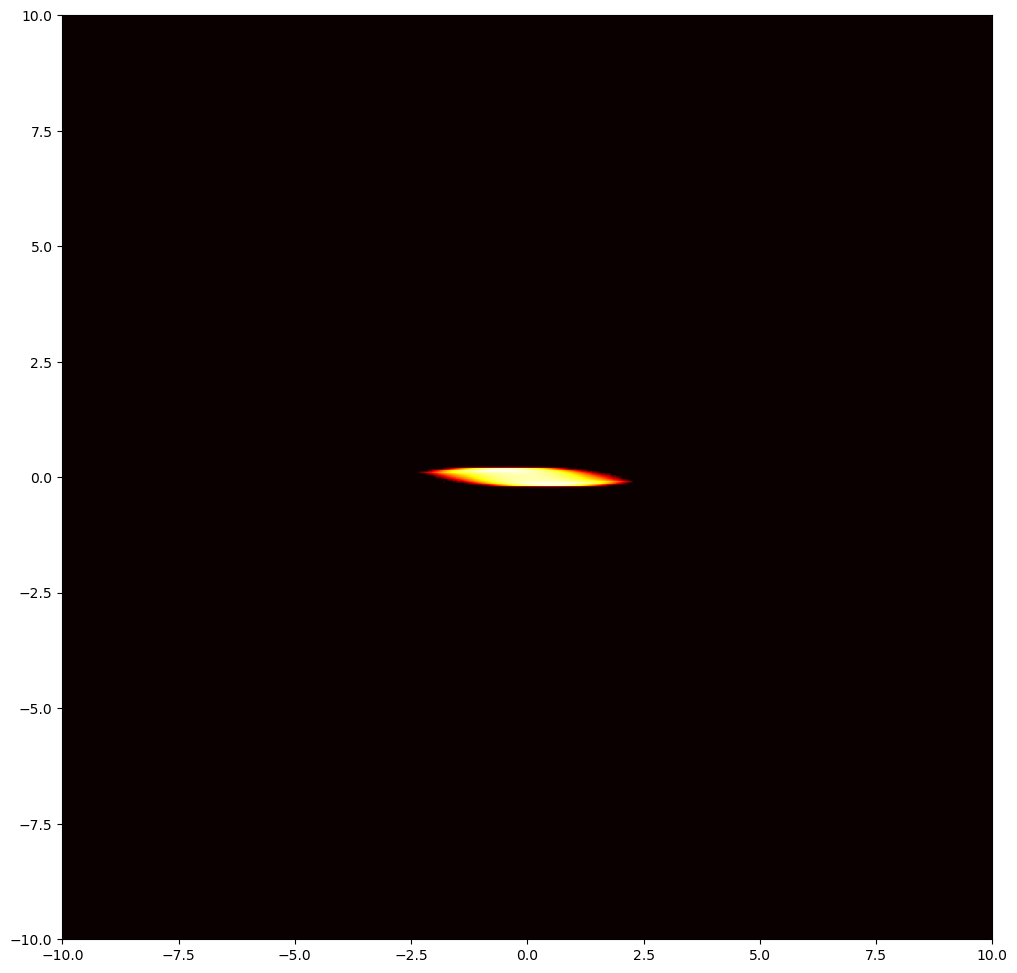

In [7]:
data = sim.trackers['1_moment'].history.flatten()

magnitudes = np.abs(data)
data = data[magnitudes <= 20]
art_dp = 10+10j
data = np.append([art_dp, -art_dp], data)
real_parts, imag_parts = data.real, data.imag
bins = 500
heatmap, xedges, yedges = np.histogram2d(real_parts, imag_parts, bins=bins)

fig, ax = plt.subplots(1, figsize=(12, 12), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.5, wspace=0.5)  # Adjust spacing between subplots

# Plot the heatmap
ax.imshow(
    np.log10(heatmap+1).T,
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    origin='lower',
    cmap='hot',
    aspect='auto',
)
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)